# Xinning_Wang-Data_Scientist-Aug_2019

In [5]:
df[:200000].to_csv('LC_Data_1.csv', index=False)
df2 = df[200000:400000].reset_index(drop=True)
df2.to_csv('LC_Data_2.csv', index=False)
df3 = df[400000:].reset_index(drop=True)
df3.to_csv('LC_Data_3.csv', index=False)

## Data Overview

#### Import packages needed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, log_loss

In [52]:
pd.set_option('display.max_columns', 500)

#### Read in data

In [6]:
df1 = pd.read_csv('LC_Data_1.csv', low_memory=False)
df2 = pd.read_csv('LC_Data_2.csv', low_memory=False)
df3 = pd.read_csv('LC_Data_3.csv', low_memory=False)
df = pd.concat([df1, df2, df3], sort=False)
df.reset_index(inplace=True, drop=True)

In [7]:
# checkout the data
df.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,0.0,8.0,KS,42.0,65000.0,NaN,Individual,10086.0,41055.0,17.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,VT,34.0,150000.0,NaN,Individual,61551.0,24661.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,8.0,IN,50.0,75000.0,NaN,Individual,7176.0,23476.0,59.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,7.0,OH,71.0,175000.0,NaN,Individual,51015.0,21569.0,50.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,FL,91.0,44000.0,NaN,Individual,19041.0,0.0,102.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find the numerical columns

In [55]:
num_cols = df.describe().columns.tolist()

## Questions

#### Section A - KPI Reporting

A KPI for a certain need shall be a feature that is easier to monitor compare to the actual target and it would have a relatively strong indicating power to the target. 

#### 1) What is the monthly total loan volume in dollars and what is the monthly average loan size?

In [56]:
# See unique values in loan issued months
df['issue_d'].value_counts()

Oct-2015    48631
Jul-2015    45962
Dec-2015    44343
Nov-2015    37530
Aug-2015    35886
Apr-2015    35427
Jan-2015    35107
May-2015    31913
Sep-2015    28641
Jun-2015    28485
Mar-2015    25400
Feb-2015    23770
Name: issue_d, dtype: int64

The dataset covers 12 month in the year of 2015, and only the months in 2015. <br>
So for convenience, I would convert issue_d to a numerical column where 1 represent Jan 2015, 2 represent Feb 2015, etc.

In [57]:
df['issue_month'] = pd.to_datetime(df['issue_d'], format='%b-%Y').apply(lambda x: x.month)

And for loan volumn in dollars, I found two features that would represent this factor, and here is to check the difference betweet the two. 

In [58]:
df[df['funded_amnt'] != df['loan_amnt']]

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,desc,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,loan_amnt,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_il_12m,open_il_24m,open_act_il,open_rv_12m,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,tax_liens,term,title,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,verification_status,zip_code,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,issue_month
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Apparently these are two bad entries, so I can drop these two rows and claim that funded_amnt and loan_amnt are two identical columns

In [59]:
df = df[df['funded_amnt'] == df['loan_amnt']].copy()
df.reset_index(inplace=True, drop=True)

Cleaning data, converting strings to numerical values

In [60]:
df['int_rate'] = df['int_rate'].apply(lambda x: float(x.replace('%', '')))
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))

In [61]:
# Monthly total loan volumn in dollars
monthly_summary = df.groupby('issue_month')['funded_amnt'].sum().apply(lambda x: int(x)).reset_index()
monthly_summary['num_of_loans'] = df.groupby('issue_month').size().values
monthly_summary['avg_int_rate'] = df.groupby('issue_month')['int_rate'].mean().apply(lambda x: round(x, 2)).values
monthly_summary['avg_duration'] = df.groupby('issue_month')['term'].mean().apply(lambda x: round(x, 2)).values
monthly_summary['avg_loan_amt'] = df.groupby('issue_month')['funded_amnt'].mean().apply(lambda x: round(x, 2)).values
# I use 30yr_mortgage rate from Freddie Mac to use as a macroeconomic factor in this
# http://www.freddiemac.com/pmms/pmms30.html
monthly_summary['30yr_mortgage'] = [3.67, 3.71, 3.77, 3.67, 3.84, 3.98, 4.05, 3.91, 3.89, 3.80, 3.94, 3.96]
monthly_summary.set_index('issue_month')

,funded_amnt,num_of_loans,avg_int_rate,avg_duration,avg_loan_amt,30yr_mortgage
issue_month,,,,,,
1.0,533132575,35107,13.05,43.84,15185.93,3.67
2.0,366908525,23770,12.73,43.82,15435.78,3.71
3.0,390003275,25400,12.77,44.02,15354.46,3.77
4.0,539401075,35427,12.79,44.00,15225.71,3.67
5.0,483189475,31913,12.75,43.80,15140.84,3.84
6.0,429777175,28485,12.76,43.94,15087.84,3.98
7.0,696238600,45962,12.71,43.88,15148.14,4.05
8.0,555331400,35886,12.59,43.99,15474.88,3.91
9.0,450246800,28641,12.66,44.27,15720.36,3.89


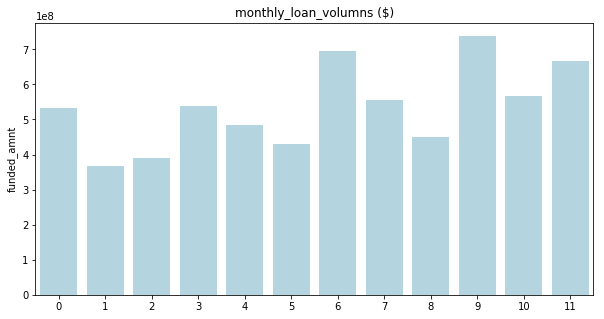

In [62]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = monthly_summary.index, 
                 y = monthly_summary['funded_amnt'], 
                 orient='v', color='Lightblue')
plt.title('monthly_loan_volumns ($)')
plt.show()

             funded_amnt
issue_month             
1.0             15185.93
2.0             15435.78
3.0             15354.46
4.0             15225.71
5.0             15140.84
6.0             15087.84
7.0             15148.14
8.0             15474.88
9.0             15720.36
10.0            15180.06
11.0            15114.50
12.0            15062.37


Text(0.5, 1.0, 'monthly_loan_volumns ($)')

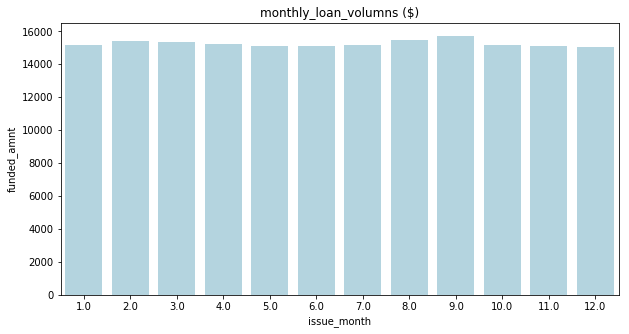

In [63]:
# Monthly Avg loan size
monthly_avg_size = df.groupby('issue_month')['funded_amnt'].mean().apply(lambda x: round(x, 2)).reset_index()
print(monthly_avg_size.set_index('issue_month'))
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = monthly_avg_size['issue_month'], 
                 y = monthly_avg_size['funded_amnt'], 
                 orient='v', color='Lightblue')
plt.title('monthly_loan_volumns ($)')

#### 2) What are the default rates by Loan Grade?

Under loan_status we have the following unique values: <br>
Fully Paid, Current, Charged Off, Late (16-30 days), Late (31-120 days), In Grace Period, Default <br>
Out of which Charged Off and Default are considered "default"

In [64]:
df['loan_defaulted'] = (df['loan_status'] == 'Default') | (df['loan_status'] == 'Charged Off')
default_rate_by_grade = (df.groupby('grade')['loan_defaulted'].mean() * 100).apply(lambda x: f'{round(x, 2)}%')
print(default_rate_by_grade)

grade
A     4.51%
B     9.75%
C    16.22%
D    23.52%
E    29.08%
F     37.6%
G    43.05%
Name: loan_defaulted, dtype: object


#### 3) Is Lending Club charging an appropriate interest rate for the risk?

Look at how different loan status are distributed across the 12 months of 2015. We still can see a clear trend that loans issued in earlier months like Januray has more paid off loans, while loan issued in later months has more current loans. 

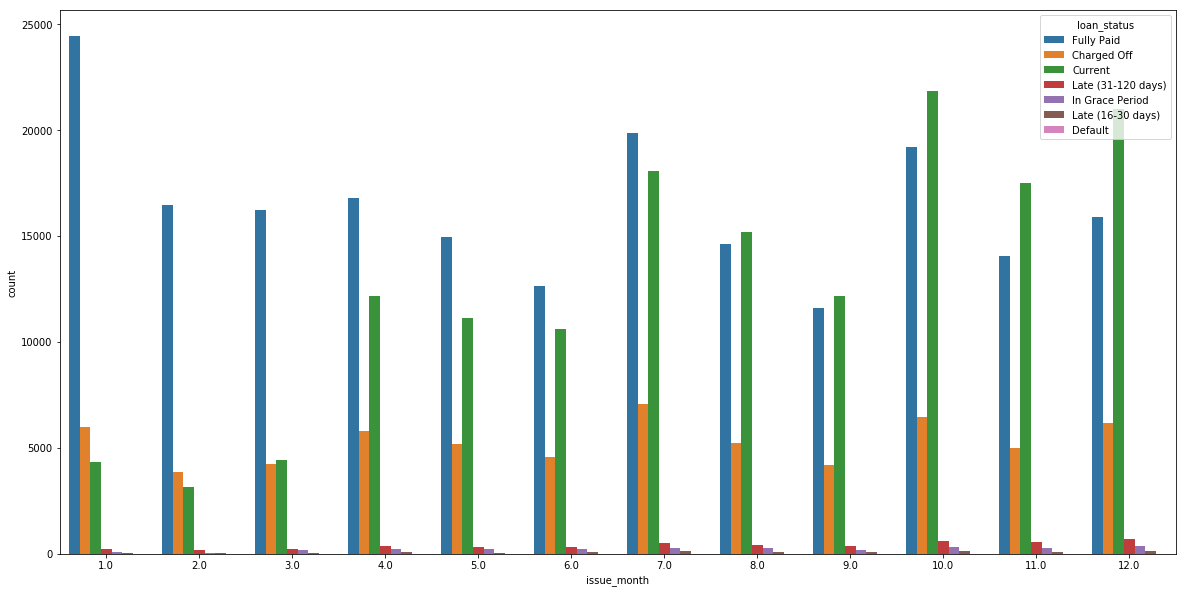

In [65]:
status_count_by_month = df.groupby('issue_month')['loan_status'].value_counts().to_frame()
status_count_by_month.columns = ['count']
status_count_by_month = status_count_by_month.reset_index().copy()
plt.figure(figsize=(20, 10))
sns.barplot(x="issue_month", y="count", hue="loan_status", data=status_count_by_month)

And the average default rate of loans issued in certain months are as shown below

In [66]:
df.groupby('issue_month')['loan_defaulted'].mean().apply(lambda x: str(round(x*100, 2))+'%')

issue_month
1.0     17.03%
2.0     16.31%
3.0     16.76%
4.0     16.31%
5.0     16.32%
6.0     16.11%
7.0     15.39%
8.0      14.6%
9.0     14.71%
10.0    13.27%
11.0    13.36%
12.0    13.92%
Name: loan_defaulted, dtype: object

Because of this clear trend, we can know the 'end of the day' default rate would be roughly around 17% if not higher. Although the loans issued in December only has 13.92% defaulted, but we can expect more of the loans from that month to default within one year time and the reset of their lives. <br>
For now I would use default statistics from Jan 2015 to estimate our default rate, since this would be the closest number to true value we have in hand, but keep in mind we might be under estimating the rate.

In [67]:
DEFAULT_RATE = df.loc[df['issue_month']==1].groupby('grade')['loan_defaulted'].mean().to_dict()
print(DEFAULT_RATE)

{'A': 0.05170699370235333, 'B': 0.1183923110528615, 'C': 0.17596953602565388, 'D': 0.24539773686877217, 'E': 0.3212079615648593, 'F': 0.39211136890951276, 'G': 0.4066390041493776}


In [68]:
# Calculate NPV of loan using term interest rate and payment
def NPV(term, int_rate, payment):
    NPV = sum([payment/(1+int_rate/1200)**(i+1) for i in range(term)])
    return NPV

Calculate NPV assuming risk free rate is 2%

In [69]:
# Calculate the NPV when issued of each loan and the adjusted 'Expected' NPV considering the probability of defaulting
df['NPV'] = df.apply(lambda x: NPV(x['term'], 2, x['installment']), axis=1)
df['adjusted_NPV'] = df.apply(lambda x: x['NPV'] * (1 - DEFAULT_RATE[x['grade']]), axis=1)

In [70]:
# The total expected rate of return
expected_rate_of_return = df['adjusted_NPV'].sum() / df['funded_amnt'].sum() - 1
print(f'Expected Rate of Return {round(expected_rate_of_return * 100, 2)}%')

Expected Rate of Return 1.57%


Based on the analysis above, LC is charging enough interest to cover their risk. <br>
Currently LC would make \\$1.57 in present value for each $100 they lent out. 

#### Section B - Modeling

1) Data is often messy, please review and QA the Lending Club dataset and summarize your thoughts on any structural issues: <br>
>  a) Is there missing data? Is the missing data random or structured? Are some attributes missing more than others?  <br>
> b) Are there any glaringly erroneous data values?

Most questions here would be solved by VLM plots <br>
> a. missing rate / rate of zeros over time <br>
> b. 1st, 50th and 99th percentile values over time <br>
> c. mean and 1 standard deviation value over time <br>

In [71]:
def vlm_plotter(feature):
    '''
    Input: 
        feature (str): name of column to plot the three vlm plots
    Output:
        None
    '''
    df_plot = df.copy()
    plt.figure(figsize=(15, 5))
    plt.title(f'{feature} Missing & Zero Ratio', fontsize=12)
    df_plot[f'{feature}_missing'] = (df_plot[feature].isnull()).astype(int)
    df_plot[f'{feature}_zero'] = (df_plot[feature] == 0).astype(int)
    df_plot.groupby('issue_month')[f'{feature}_missing'].mean().plot()
    df_plot.groupby('issue_month')[f'{feature}_zero'].mean().plot()
    plt.legend()
    plt.show()
    plt.figure(figsize=(15, 5))
    plt.title(f'{feature} 1st-50th-99th Percentile', fontsize=12)
    df_plot = df_plot[df_plot[feature].notnull()].copy()
    df_plot.reset_index(inplace=True, drop=True)
    df_plot.groupby('issue_month')[feature].agg(lambda x: np.percentile(x, 1)).plot()
    df_plot.groupby('issue_month')[feature].agg(lambda x: np.percentile(x, 50)).plot()
    df_plot.groupby('issue_month')[feature].agg(lambda x: np.percentile(x, 99)).plot()
    plt.show()
    data = df_plot.groupby('issue_month')[feature].mean().reset_index()
    data.columns = ['issue_month', 'mean']
    data = data.assign(std=df_plot.groupby('issue_month')[feature].std().values)
    plt.figure(figsize=(15, 5))
    plt.title(f'{feature} Mean and 1 std CI', fontsize=12)
    data['mean'].plot()
    (data['mean'] + data['std']).plot()
    (data['mean'] - data['std']).plot()
    plt.show()
    del df_plot, data

Since the vlm_plotter function can only handle numerical features, we would only feed numerical columns to the plotter. But first we found the columns with missing ratio so high that it would be impossible to derive any information out of it. 

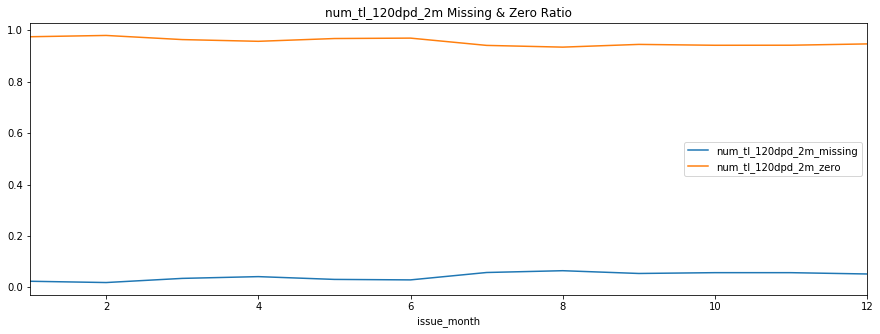

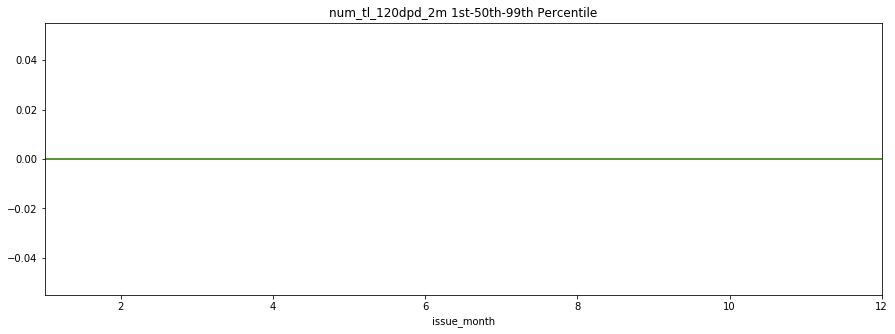

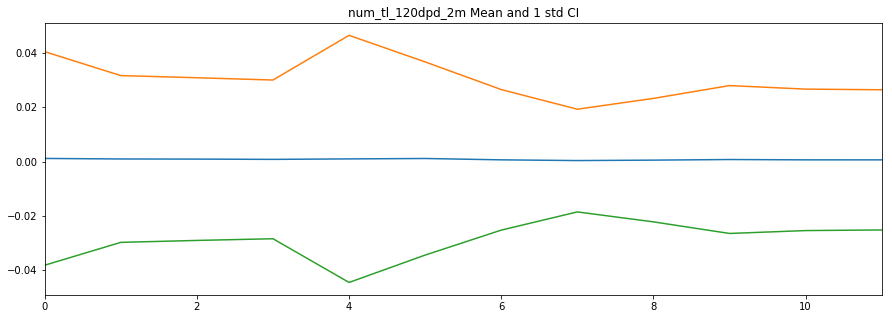

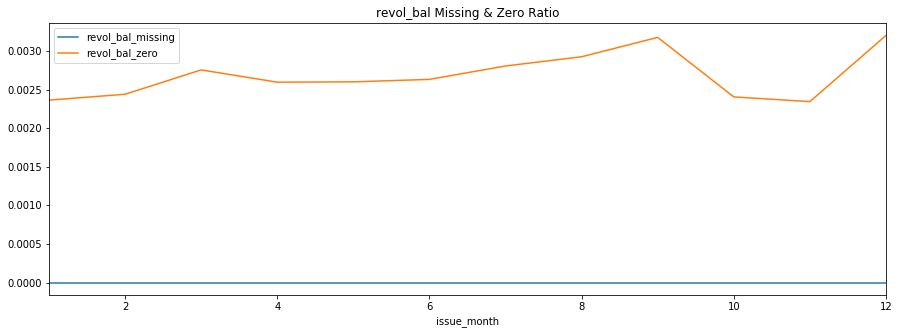

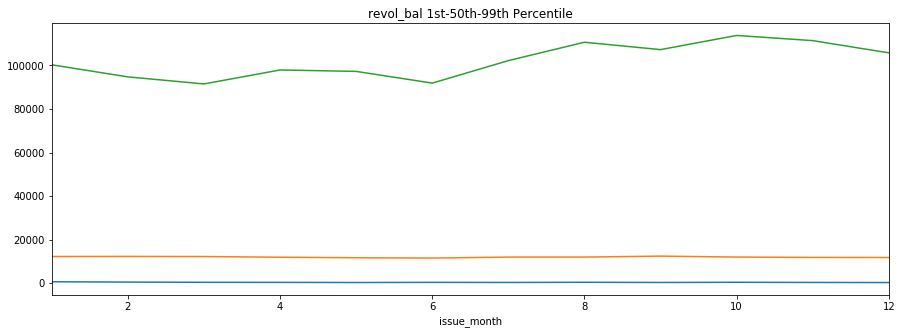

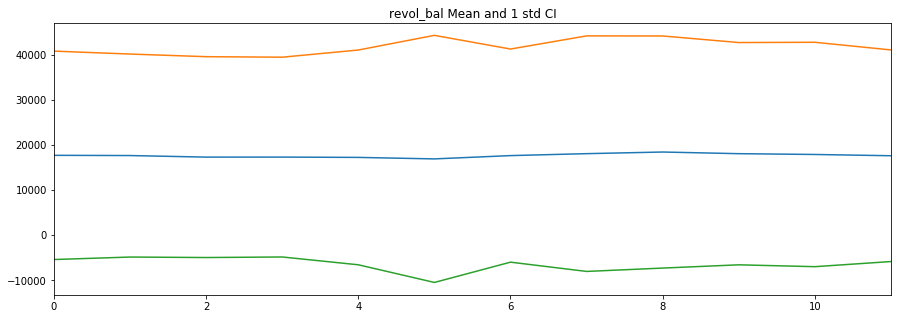

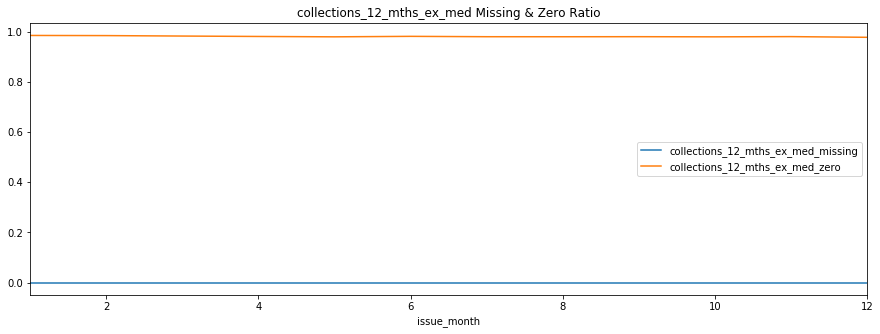

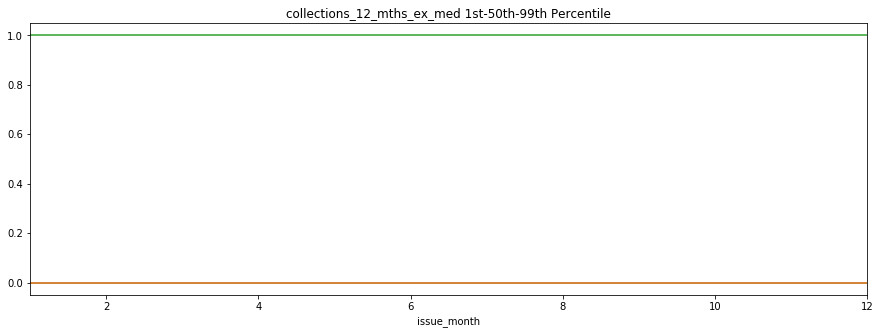

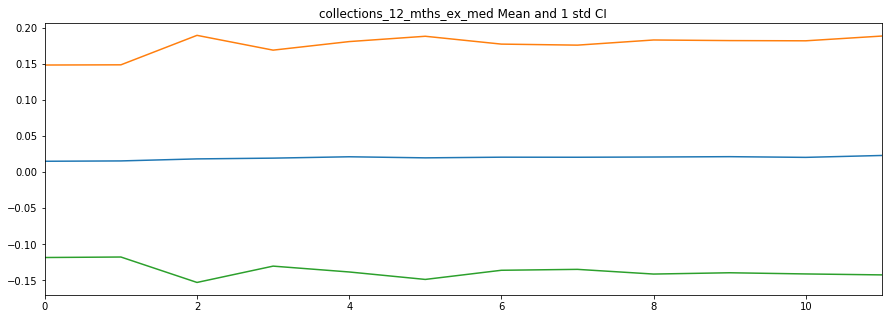

In [72]:
high_missing_columns = df.isnull().mean()[df.isnull().mean() > 0.8].index.tolist()
num_cols = list(set(num_cols) - set(high_missing_columns))

# Here I only showed plots for three features ton save space
# We have in total 50+ features to plot and would ressult in 150+ plots
for col in num_cols[:3]:
    vlm_plotter(col)

The for loop above went through 50+ numerical features from the data and plotted 150+ plots. Judging from the plots There are no significant strange or structural abnormality in the numerical features. 

#### 2) Using any format and any modeling technique that you prefer, please create a model to predict default within the Lending Club dataset.

In [73]:
# Drop features with high missing rates
df.drop(high_missing_columns, axis=1, inplace=True)

In [74]:
# Drop features that does not provide information or not allowed to use in modeling
cols_to_drop = ['issue_d', 'emp_title', 'zip_code']
df.drop(cols_to_drop, axis=1, inplace=True)

In [75]:
# convert emp_length to int
def emp_length_helper(s):
    try:
        s = s.split()[0]
        if '<' in s:
            return 0
        elif '+' in s:
            return 10
        else:
            year = int(s)
            return year
    except AttributeError:
        return np.nan
    
df['emp_length'] = df['emp_length'].apply(emp_length_helper)

In [76]:
# Convert grade to ordinal
alphabet_map = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
}
df['grade'] = df['grade'].map(alphabet_map)

In [77]:
# Convert sub grade to ordinal int
df['sub_grade'] = df['sub_grade'].apply(lambda x: int(x[1:]))

In [78]:
# Convert term to binary since we only have two options of terms
df['term'] = df['term'] == 60

In [79]:
# Convert cr line history to ages
# We expect that longer credit history is, less likely to default
df['creditline_age_in_days'] = (pd.datetime(2016, 1, 1) - pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')).apply(lambda x: x.days)
df.drop('earliest_cr_line', axis=1, inplace=True)

In [80]:
# title and purpose hold the same information
df[['title', 'purpose']].isnull().sum()

title      132
purpose      0
dtype: int64

In [81]:
# since purpose has a better quality data, we drop title
df.drop('title', axis=1, inplace=True)

In [82]:
# convert revol_util to float
df['revol_util'] = df['revol_util'].apply(lambda x: np.nan if str(x) == 'nan' else x.replace('%', ''))

In [83]:
# application type to binary since we only have two options
df['application_type'] = df['application_type'] == 'Individual'

In [84]:
# initial_list_status to binary since we only have two options
df['initial_list_status'] = df['initial_list_status'] == 'w'

Add 30 yr mortgage rate to the data

In [85]:
df = pd.merge(df, monthly_summary[['issue_month', '30yr_mortgage']], 
              left_on='issue_month', right_on='issue_month', how='left')

See if there is a relationship between mortgage rate and default rate

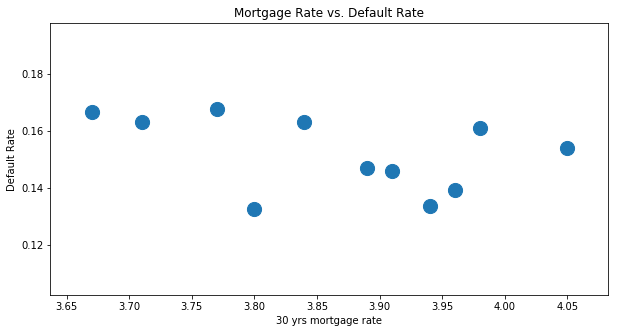

In [86]:
plt.figure(figsize=(10, 5))
plt.title('Mortgage Rate vs. Default Rate', fontsize=12)
mort = df.groupby('30yr_mortgage')['loan_defaulted'].mean().reset_index()
plt.scatter(mort['30yr_mortgage'], mort['loan_defaulted'], s=200)
plt.xlabel('30 yrs mortgage rate')
plt.ylabel('Default Rate')
plt.show()

In [87]:
# Test if correlation is significant
pearson = pearsonr(mort['30yr_mortgage'], mort['loan_defaulted'])
print(f'Pearson Corr: {round(pearson[0], 2)} \np-value: {round(pearson[1], 2)}')

Pearson Corr: -0.43 
p-value: 0.19


p-value of 0.19 failed to proof that this is a statistical significant relationship between the 30 year mortgage rate and default rate.

The risk of the loans come from three originations:
> a. Customers' creditability <br>
> b. Loan structure, is it appropriate and well defined <br>
> c. Macro Economics <br>

Let's try to identify features we have in this dataset based on this three categories.

In [88]:
customer = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
            'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 
            'emp_length', 'home_ownership', 'inq_last_6mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
            'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 
            'mths_since_last_major_derog', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
            'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
            'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
            'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec',  
            'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'tax_liens', 'tot_cur_bal',
            'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
            'total_rev_hi_lim', 'verification_status', 'addr_state']
loan = ['application_type', 'funded_amnt', 'funded_amnt_inv', 'initial_list_status', 'installment', 'int_rate',
        'policy_code', 'term']
econ = ['addr_state', '30yr_mortgage']
derived = ['grade', 'sub_grade']

Because two reasons:
> all loans from this dataset are from the year of 2015, there would be limited macroeconomic variance during that time window <br>
> we don't have enough macroeconomic features from this dataset

I would choose to ignore the impact of macroeconomy to the loan.

Hypothesis: Loan Grade is based on loan structure

In [89]:
s = ['application_type','funded_amnt','funded_amnt_inv','initial_list_status','installment','policy_code','term']

In [46]:
X = df[s].values
y = df['grade'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf = xgb.XGBClassifier(learning_rate=0.05,
                        n_estimators=1000,
                        max_depth=3,
                        min_child_weight=6,
                        gamma=0,
                        subsample=0.8,
                        num_class=5,
                        colsample_bytree=0.8,
                        objective= 'multi:softmax',
                        nthread=8,
                        scale_pos_weight=1,
                        seed=42)

clf.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred = clf.predict(X_train)
# Make predictions on test data
y_test_pred = clf.predict(X_test)
print(f'Accuracy Score: {round(accuracy_score(y_test, y_test_pred)*100, 2)}%')

Accuracy Score: 81.16%


In [48]:
# See the feature importance in this model
loan_feature_importance = pd.DataFrame(zip(s, clf.feature_importances_))
loan_feature_importance.columns = ['feature', 'importance']
loan_feature_importance

# Step wise logistic reg. recommended. When found the highest EXP, - remove int. then look at loan amount and income. 

,feature,importance
0,application_type,0.008586
1,funded_amnt,0.148939
2,funded_amnt_inv,0.166826
3,initial_list_status,0.184004
4,installment,0.171796
5,policy_code,0.000000
6,term,0.319850


It is obvious that int_rate is dominating this model. Let's take a closer look at int_rate vs. grade

In [ ]:
X = df[['int_rate']].values
y = df['grade'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf = xgb.XGBClassifier(learning_rate=0.05,
                        n_estimators=1000,
                        max_depth=3,
                        min_child_weight=6,
                        gamma=0,
                        subsample=0.8,
                        num_class=5,
                        colsample_bytree=0.8,
                        objective= 'multi:softmax',
                        nthread=8,
                        scale_pos_weight=1,
                        seed=42)

clf.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred = clf.predict(X_train)
# Make predictions on test data
y_test_pred = clf.predict(X_test)
print(f'Accuracy Score: {round(accuracy_score(y_test, y_test_pred)*100, 2)}%')

This showed that the loan grade is almost a rule based cut on int_rate, and the two are almost identicle from the perspective of information provided. 

In [ ]:
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    '''
    Helper function to get 5 kinds of performance metrics for binary classification models
    Input:
        y_train (np.array): binary (0/1)
        y_train_pred (np.array): continuous between 0 and 1
        y_test (np.array): binary (0/1)
        y_test_pred (np.array): continuous between 0 and 1
        threshold (float): cut off point to determine the target
    Output:
        None
    '''
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)
    
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    '''
    Helper function to get 5 kinds of performance metrics for binary classification models
    Input:
        y_train (np.array): binary (0/1)
        y_train_pred (np.array): continuous between 0 and 1
        y_test (np.array): binary (0/1)
        y_test_pred (np.array): continuous between 0 and 1
    Output:
        None
    '''
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.figure(figsize=(12, 10))
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

First try to build a model on all loan related features, this model is expected to answer the question of what kind of loan structures are more likely to be defaulted?

In [90]:
df['loan_deliq'] = df['loan_status'].apply(lambda x: x in ['Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Default'])

In [91]:
df.describe().columns.tolist()

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'policy_code',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_bal',
 'sub

In [ ]:
for col in df.describe().columns.tolist():
    df[col] = df[col].apply(lambda x: np.log(x+1))

In [ ]:
X = df[loan].values
y = df['loan_deliq'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf_loan = xgb.XGBClassifier(learning_rate=0.05,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=6,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             eval_metric='auc',
                             nthread=8,
                             scale_pos_weight=1,
                             seed=42)

clf_loan.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred_loan = clf_loan.predict(X_train)
p_train_pred_loan = clf_loan.predict_proba(X_train)[:, 1]
# Make predictions on test data
y_test_pred_loan = clf_loan.predict(X_test)
p_test_pred_loan = clf_loan.predict_proba(X_test)[:, 1]

Plot the ROC curve

In [ ]:
get_performance_metrics(y_train, p_train_pred_loan, y_test, p_test_pred_loan, threshold=0.5)
plot_roc_curve(y_train, p_train_pred_loan, y_test, p_test_pred_loan)

Plot lift chart of this model, which visualize the ordering power of the model

In [ ]:
df_test_loan = pd.DataFrame(X_test, columns=loan)
df_test_loan['loan_defaulted'] = y_test
df_test_loan['pred'] = pd.cut(p_test_pred_loan, 100)
plt.figure(figsize=(15, 10))
plt.title('Lift Chart of Loan Model', fontsize=12)
df_test_loan.groupby('pred')['loan_defaulted'].mean().plot()

Generate one-hot-encoders for multi-class categorical features

In [ ]:
multi_class = ['home_ownership', 'purpose', 'verification_status', 'addr_state']
df_dum = pd.get_dummies(df[multi_class], drop_first=True)
customer = list((set(customer) - set(multi_class)) | set(df_dum.columns.tolist()))
df_ohe = pd.concat([df.drop(multi_class, axis=1), df_dum], axis=1, sort=False)
df_ohe.reset_index(inplace=True, drop=True)

Train model on customer related features, this model is expected answer the question of what kind of customers are more likely to default a loan.

In [ ]:
X = df_ohe[customer].values
y = df_ohe['loan_defaulted'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf_cust = xgb.XGBClassifier(learning_rate=0.05,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=6,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             eval_metric='auc',
                             nthread=8,
                             scale_pos_weight=1,
                             seed=42)

clf_cust.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred_cust = clf_cust.predict(X_train)
p_train_pred_cust = clf_cust.predict_proba(X_train)[:, 1]
# Make predictions on test data
y_test_pred_cust = clf_cust.predict(X_test)
p_test_pred_cust = clf_cust.predict_proba(X_test)[:, 1]

Plot the ROC curve

In [ ]:
get_performance_metrics(y_train, p_train_pred_cust, y_test, p_test_pred_cust, threshold=0.5)
plot_roc_curve(y_train, p_train_pred_cust, y_test, p_test_pred_cust)

Plot lift chart of this model, which visualize the ordering power of the model

In [ ]:
df_test_cust = pd.DataFrame(X_test, columns=customer)
df_test_cust['loan_defaulted'] = y_test
df_test_cust['pred'] = pd.cut(p_test_pred_cust, 100)
plt.figure(figsize=(15, 10))
plt.title('Lift Chart of Customer Model', fontsize=12)
df_test_cust.groupby('pred')['loan_defaulted'].mean().plot()

Score the two models on all data

In [ ]:
df = pd.concat([df, df_dum], axis=1, sort=False)
df.reset_index(inplace=True, drop=True)
df['loan_score'] = clf_loan.predict_proba(df[loan].values)[:, 1]
df['cust_score'] = clf_cust.predict_proba(df[customer].values)[:, 1]

Build a simple logistic regression on top of the two estimators for "how risky this loan is?" and "how risky this customer is?"

In [ ]:
lr = LogisticRegression(solver='lbfgs')

X = df[['loan_score', 'cust_score']].values
y = df['loan_defaulted'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

lr.fit(X_train, y_train)

# Make prediction on the training data
y_train_pred = lr.predict(X_train)
p_train_pred = lr.predict_proba(X_train)[:, 1]
# Make predictions on test data
y_test_pred = lr.predict(X_test)
p_test_pred = lr.predict_proba(X_test)[:, 1]

Plot ROC curve

In [ ]:
get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5)
plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

We can see a solid improvement just by looking at the ROC AUC score. 

Conclusion--
I would assume this model can be used to estimate risks of future loans. The structure I set up above captures two parts of the risk. "Is this customer a trust worthy customer?" and "Is this a high risk loan structure." <br>
In general, higher risk customers would generate more income for Lending Club, but as for loan structure risk, LC should be careful giving out high risk loans to high risk customers. I would recommend similar to the loan grade, we cut customers into grade tiers as well and cross check how many loans falls into each bivariate bin. From their LC would be able to improve the credit estimation of future loans better. 
As for future works, I would hope to be given more data from more years where I can take into account the macroeconomic factors, or if I have access to monthly payment of current and past loans I'm able to learn more about the loans' lifecycle. 

#### Section C

The topic I choose would be "Decision Trees"

#### a) Someone with significant mathematical experience.

Decision tree is a kind of decision making tool that we use to generate insights from data and make predictions. It is a flowchart like structure where the tree recursively "ask" True or False questions and make the decision accroding to the series of answers. <br>
Take a binary classification as an example. The loss function we use in decision trees are often either entropy or gini, both of which measures the pureness of the data splited into two leaves. The loss function would be maximized if in a leaf half would be in class A and half would be in class B while it would be minimized if all of the data points are belong to one class. Eventually we would want each leaf to have only one kind of target variable. <br>
For each question, the tree would seek to maximize the "information gain", which is simply the drop in entroy or gini loss. The algorithm would find the best cut off point of the best feature to provide the maximum information gain at the point. Notice that this would be a greedy algorithm, which means this would not find the global optimum. <br>
Then the tree would recursively find the local optimum split points until each leaf only has one data point or an early stopping criteria is met. <br>
The algorithm can not only be used as classification algorithm as discussed above, but also can be used as a regression algorithm where the predicted output of a data point would be the average value of all the data points belnging to that leaf. <br>
The advantage of decision trees is that its totally understandable, it can give a clear explanation of why the output is what it is. Plus its is easy to train, prune to outlier and missing value. <br>
Downside of decision trees is obvious as well. It is easy to overfit. Since if we do not define a early stopping criteria, then eventually the tree would grow so deep that each leaf has one data point, which would for sure minimize the error, but that would not generalize well. But on the other hand, a tree that is too shallow would not be powerful enough to caputure data insights. 

#### b) Someone with little mathematical experience.

Decision tree is a flowchart like decision making tool where it ask a series of questions to predict the outcome for events that havn't happened. <br>
For example it we are to predict someone's gender from their height and weight, then the decision tree would be something like this. If height is higher than 6 ft, then its a male. If height is lower than 6 ft and weight is more than 140 lb, then is a male, and if weight is less than 140 lb its a girl. <br>
This would be a simple example of how decision tree works. As you can see, with just a depth of two, meaning asking two questions to split the population, the outcome is not going to be very accurate. There will be males who are shorter than 6 ft and females that are taller. But generally, if someone is taller than 6 ft, its more than likely that it is a male. <br>
So later on we are able to use this model to predict the target, in our case 'gender', given the features height and weight. 